# Introduction:

The dataset is pretty large at 275547 observations
It includes user data (such as Age, Sex, Language, signup method, affiliate paths)

Signup dates, Date of first activity.

Session info based on in-website actions and their duration is also provided.

The target to be predicted is whether the user will book a place to stay on airbnb, and which country it will be in.
Only 10 country labels are used at the current scope. All other countries are grouped under the "other" label.


In [16]:
library(xgboost)
library(readr)
library(stringr)
library(caret)
library(car)
library(tidyverse)
library(skimr)
library(mlr)
library(parallelMap)
setwd('C:/Users/sprot/Documents/GitHub/airbnb')

In [17]:
set.seed(333)
# load data---------------------
train = read_csv('train_users_2.csv')
trainBackup = read_csv('train_users_2.csv')
test = read_csv('test_users.csv')
labels = train['country_destination']
train = train[-grep('country_destination', colnames(train))]
sessions = read_csv('sessions.csv')
# combine train and test data
dfAll = rbind(train,test)
# remove date_first_booking (since this is not useful in a prediction scope)
dfAll = dfAll[-c(which(colnames(dfAll) %in% c('date_first_booking')))]
# replace missing values (-1 is easier to filter upon, also helps with inconsistencies in some functions)
dfAll[is.na(dfAll)] = -1

# split date_account_created in year, month and day
dac = as.data.frame(str_split_fixed(dfAll$date_account_created, '-', 3))
dfAll['dac_year'] = dac[,1]
dfAll['dac_month'] = dac[,2]
dfAll['dac_day'] = dac[,3]
dfAll = dfAll[,-c(which(colnames(dfAll) %in% c('date_account_created')))]
head(dfAll, n=100)
skim(dfAll)

dfSome = dfAll[1:50,] #open this to not make R hang for long
sessSome = sessions[1:1000,]

Parsed with column specification:
cols(
  id = col_character(),
  date_account_created = col_date(format = ""),
  timestamp_first_active = col_double(),
  date_first_booking = col_date(format = ""),
  gender = col_character(),
  age = col_double(),
  signup_method = col_character(),
  signup_flow = col_integer(),
  language = col_character(),
  affiliate_channel = col_character(),
  affiliate_provider = col_character(),
  first_affiliate_tracked = col_character(),
  signup_app = col_character(),
  first_device_type = col_character(),
  first_browser = col_character(),
  country_destination = col_character()
)
Parsed with column specification:
cols(
  id = col_character(),
  date_account_created = col_date(format = ""),
  timestamp_first_active = col_double(),
  date_first_booking = col_date(format = ""),
  gender = col_character(),
  age = col_double(),
  signup_method = col_character(),
  signup_flow = col_integer(),
  language = col_character(),
  affiliate_channel = col_character(),

id,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day
gxn3p5htnn,2.009032e+13,-unknown-,-1,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,06,28
820tgsjxq7,2.009052e+13,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,05,25
4ft3gnwmtx,2.009061e+13,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,09,28
bjjt8pjhuk,2.009103e+13,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,2011,12,05
87mebub9p4,2.009121e+13,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,09,14
osr2jwljor,2.010010e+13,-unknown-,-1,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,2010,01,01
lsw9q7uk0j,2.010010e+13,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,2010,01,02
0d01nltbrs,2.010010e+13,FEMALE,47,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,2010,01,03
a1vcnhxeij,2.010010e+13,FEMALE,50,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,2010,01,04
6uh8zyj2gn,2.010010e+13,-unknown-,46,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,2010,01,04


variable,type,stat,level,value,formatted
id,character,missing,.all,0.000000e+00,0
id,character,complete,.all,2.755470e+05,275547
id,character,n,.all,2.755470e+05,275547
id,character,min,.all,1.000000e+01,10
id,character,max,.all,1.000000e+01,10
id,character,empty,.all,0.000000e+00,0
id,character,n_unique,.all,2.755470e+05,275547
timestamp_first_active,numeric,missing,.all,0.000000e+00,0
timestamp_first_active,numeric,complete,.all,2.755470e+05,275547
timestamp_first_active,numeric,n,.all,2.755470e+05,275547


Replacing missing values with -1 makes it easier to filter upon. Also helps with inconsistencies in some functions)

In [18]:
#session summaries for users---------------------
sessionsGrouped = sessions %>%
    group_by(user_id, action_detail) %>%
      summarize(total_time_secs = sum(secs_elapsed),
           action_count = n()) %>%
             ungroup()

head(sessionsGrouped, 25)

globalSessSumm = sessionsGrouped %>% #per user basis
  group_by(action_detail) %>%
    summarize(global_time_spent = sum(total_time_secs),
              global_count = n())

globalSessSumm = globalSessSumm %>% #totals across users
  mutate(mean_time = global_time_spent / global_count) %>%
    arrange(desc(mean_time))

head(globalSessSumm, 25)


user_id,action_detail,total_time_secs,action_count
00023iyk9l,change_trip_characteristics,1447,2
00023iyk9l,confirm_email_link,567165,1
00023iyk9l,dashboard,4462,4
00023iyk9l,header_userpic,3198,2
00023iyk9l,message_post,129817,1
00023iyk9l,oauth_response,NA,1
00023iyk9l,p3,60596,6
00023iyk9l,p5,40132,5
00023iyk9l,pending,0,1
00023iyk9l,similar_listings,330,3


action_detail,global_time_spent,global_count,mean_time
update_listing_description,2730890673,4053,673794.89
listing_reviews_page,502282471,2057,244182.05
view_identity_verifications,1190991,6,198498.50
message_to_host_change,1393073668,7980,174570.64
guest_itinerary,141947562,873,162597.44
guest_receipt,32449775,223,145514.69
wishlist_note,31021394,218,142299.97
create_payment_instrument,9094492,69,131804.23
translate_listing_reviews,63695846,508,125385.52
alteration_request,2972818,24,123867.42


Surprisingly, at the current stage, the xgboost performed rather well even when not using the session data at all

In [20]:
# split timestamp_first_active in year, month and day----------------
head(dfAll$timestamp_first_active) #here the timestamp is a continuous number, not separated by dashes like dac above.
summary(dfAll$timestamp_first_active)
vecVersion = as.character(dfAll$timestamp_first_active) #needed this conversion in order to make the year work, some issue with R implicit types (li)

dfAll['tfa_year'] = substring(vecVersion,1,4)
tail(dfAll$tfa_year)

dfAll['tfa_month'] = substring(as.character(dfAll['timestamp_first_active']), 5, 6)
head(dfAll$tfa_month)

dfAll['tfa_day'] = substring(as.character(dfAll['timestamp_first_active']), 7, 8)
dfAll = dfAll[,-c(which(colnames(dfAll) %in% c('timestamp_first_active')))]
head(dfAll$tfa_day)

# clean Age by removing values
dfAll[dfAll$age < 13 | dfAll$age > 82,'age'] = -1

[1] 2.009032e+13 2.009052e+13 2.009061e+13 2.009103e+13 2.009121e+13
[6] 2.010010e+13

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
2.009e+13 2.013e+13 2.014e+13 2.013e+13 2.014e+13 2.014e+13 

[1] "2014" "2014" "2014" "2014" "2014" "2014"

[1] "09" "09" "09" "09" "09" "09"

[1] "03" "03" "03" "03" "03" "03"

Ages < 13 and > 82 could be from people providing inaccurate information. We believe the amount of users actually being of that age is insignificant, thus we replace these ages with -1 to reduce noise

In [21]:
# one-hot-encoding features--------------------
oheFeats = c('gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser')
dummies = dummyVars(~ gender + signup_method + signup_flow + language + affiliate_channel + affiliate_provider + first_affiliate_tracked + signup_app + first_device_type + first_browser, data = dfAll)
dfAllOhe = as.data.frame(predict(dummies, newdata = dfAll))
dfAllCombined = cbind(dfAll[,-c(which(colnames(dfAll) %in% oheFeats))],dfAllOhe)

# split train and test--------------
X = dfAllCombined[dfAllCombined$id %in% train$id,]
y = recode(labels$country_destination,'NDF'=0, 'US'=1, 'other'=2, 'FR'=3, 'CA'=4, 'GB'=5, 'ES'=6, 'IT'=7, 'PT'=8, 'NL'=9, 'DE'=10, 'AU'=11)
xTest = dfAllCombined[dfAllCombined$id %in% test$id,]
head(X[,-1], n=25)

age,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,gender-unknown-,genderFEMALE,genderMALE,...,first_browserSilk,first_browserSiteKiosk,first_browserSlimBrowser,first_browserSogou Explorer,first_browserStainless,first_browserTenFourFox,first_browserTheWorld Browser,first_browserUC Browser,first_browserwOSBrowser,first_browserYandex.Browser
-1,2010,06,28,2009,09,03,1,0,0,...,0,0,0,0,0,0,0,0,0,0
38,2011,05,25,2009,09,03,0,0,1,...,0,0,0,0,0,0,0,0,0,0
56,2010,09,28,2009,09,03,0,1,0,...,0,0,0,0,0,0,0,0,0,0
42,2011,12,05,2009,09,03,0,1,0,...,0,0,0,0,0,0,0,0,0,0
41,2010,09,14,2009,09,03,1,0,0,...,0,0,0,0,0,0,0,0,0,0
-1,2010,01,01,2010,09,03,1,0,0,...,0,0,0,0,0,0,0,0,0,0
46,2010,01,02,2010,09,03,0,1,0,...,0,0,0,0,0,0,0,0,0,0
47,2010,01,03,2010,09,03,0,1,0,...,0,0,0,0,0,0,0,0,0,0
50,2010,01,04,2010,09,03,0,1,0,...,0,0,0,0,0,0,0,0,0,0
46,2010,01,04,2010,09,03,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# train xgboost-------------------
xgb = xgboost(data = data.matrix(X[,-1]), # https://xgboost.readthedocs.io/en/latest/parameter.html for parameter settings
               label = y, 
               eta = 0.1,
               max_depth = 9, 
               nround=15, 
               subsample = 0.5,
               colsample_bytree = 0.5,
               seed = 333,
               eval_metric = 'merror', 
               objective = 'multi:softprob', 
               num_class = 12,
               nthread = 3
)

#This can take some time. If we need it to be faster it makes sense to subset the training data or reduce depth

# predict values in test set
yPred = predict(xgb, data.matrix(xTest[,-1]))

[1]	train-merror:0.379914 
[2]	train-merror:0.387714 
[3]	train-merror:0.378012 
[4]	train-merror:0.376841 
[5]	train-merror:0.369467 
[6]	train-merror:0.367799 
[7]	train-merror:0.365044 
[8]	train-merror:0.365681 
[9]	train-merror:0.365213 
[10]	train-merror:0.363934 
[11]	train-merror:0.362636 
[12]	train-merror:0.362210 
[13]	train-merror:0.361460 
[14]	train-merror:0.361123 
[15]	train-merror:0.360214 


In [24]:
# top 5 classes / labers
predictions = as.data.frame(matrix(yPred, nrow=12))
rownames(predictions) = c('NDF','US','other','FR','CA','GB','ES','IT','PT','NL','DE','AU')
predictionsTop5 = as.vector(apply(predictions, 2, function(x) names(sort(x)[12:8])))


ids = NULL
for (i in 1:NROW(xTest)) {
  idx = xTest$id[i]
  ids = append(ids, rep(idx,5))
}
myResult = NULL
myResult$id = ids
myResult$country = predictionsTop5


myResult = as.data.frame(myResult)



id,country
5uwns89zht,NDF
5uwns89zht,US
5uwns89zht,other
5uwns89zht,FR
5uwns89zht,IT
jtl0dijy2j,NDF


In [26]:
head(myResult,20)


id,country
5uwns89zht,NDF
5uwns89zht,US
5uwns89zht,other
5uwns89zht,FR
5uwns89zht,IT
jtl0dijy2j,NDF
jtl0dijy2j,US
jtl0dijy2j,other
jtl0dijy2j,FR
jtl0dijy2j,GB


Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

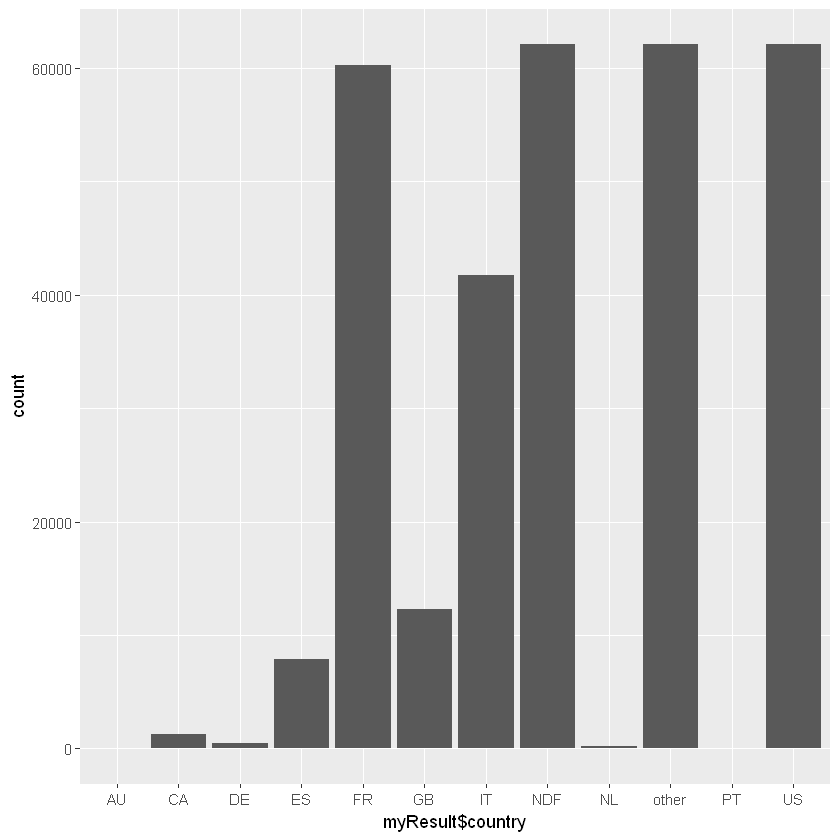

In [27]:
ggplot(data=myResult, aes(x=myResult$country)) + geom_histogram(stat = 'count')

# Interesting possibilities
**Location Based**

Proximity (determined by IP location--> nearest airport) ---> API with air tickets search engines for prices. 

Visa requirements: pull from wikipedia or some API. Prioritize countries where visa is not required.

Language setting (already have 1, would be nice to have option for more under user profile)
Currency setting

**Activity metrics:**
Max logins within a 7-day window, and the window that it was observed on
Mean logins in the most recent weeks.
Most recent week with logins above a threshold
Signup date
First search date 
First booking

**Lag parameters:** Based on pairing above metrics 
Intuitively some would be more useful than others, but ML can help us identify the best combinations and exhaustively test all of them.



Eventually, we would end up with a lot of variables. Different combinations should be tested to find a good model. 

Also, we should be careful to prevent overfitting, by adding too many of them. 
K-fold Cross-validation can help us achieve that.

# References:
Extreme gradiant boost parameters:

https://xgboost.readthedocs.io/en/latest/parameter.html

DCG / normalized DCG: 

http://blog.thedigitalgroup.com/vijaym/measuring-search-relevance-using-ndcg/

https://en.wikipedia.org/wiki/Discounted_cumulative_gain